In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from pandas.plotting import table
from scipy.interpolate import make_interp_spline, BSpline
import json

            
#with open('/Users/lisajin/Documents/Smnology/company/ODI.json') as f: 
    #data = json.load(f)

#df=pd.DataFrame(data)



In [5]:
#import data from file
with open('/Users/lisajin/Documents/Smnology/company_data/ODI.json') as file:
    data = json.load(file)
    #parse out saturation data, pulse data and sleep stage data
df = pd.DataFrame(data['o2Arr'],columns=['Oxygen_sec'])#O2 is by second
df['pulse_sec'] = pd.DataFrame(data['prArr'])#pulse is by second
df['stage_min']= pd.DataFrame(data['stageArr'])#this stage is by minute


In [6]:
stage_min=df['stage_min'][0:412]

In [7]:
stage_sec=stage_min.repeat(60)
stage_sec = stage_sec.reset_index(drop = True)
    

In [8]:
df['stage_sec']=stage_sec

In [9]:
df.head()


,Oxygen_sec,pulse_sec,stage_min,stage_sec
0,97.99,68,0.0,0.0
1,98.01,68,0.0,0.0
2,98.04,68,0.0,0.0
3,98.06,68,0.0,0.0
4,98.10,68,0.0,0.0


In [10]:
df['stage_sec'] = df['stage_sec'].fillna(0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24746 entries, 0 to 24745
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Oxygen_sec  24746 non-null  float64
 1   pulse_sec   24746 non-null  int64  
 2   stage_min   412 non-null    float64
 3   stage_sec   24746 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 773.4 KB


/Users/lisajin/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Oxygen_sec'>

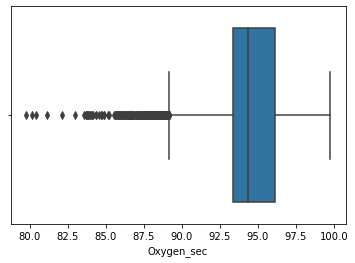

In [12]:
sns.boxplot(df.Oxygen_sec)

In [13]:
#establish a metric or standard oxygen level (not the baseline because we cannot measure the baseline)
#we acquire this by excludig the outliers see in the above graph and get the standard metric o2
#we exclude the outliers that happen due to the machine malfunction

Q1 = df['Oxygen_sec'].quantile(0.25)
Q3 = df['Oxygen_sec'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df['Oxygen_sec'] >= Q1 - 1.5 * IQR) & (df['Oxygen_sec'] <= Q3 + 1.5 *IQR)
df_filter=df.loc[filter]  

In [14]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24325 entries, 0 to 24745
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Oxygen_sec  24325 non-null  float64
 1   pulse_sec   24325 non-null  int64  
 2   stage_min   412 non-null    float64
 3   stage_sec   24325 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 950.2 KB


In [15]:
oxygen_metric=df_filter['Oxygen_sec'].mean()

In [16]:
oxygen_metric #this is just the average of the night, not the reference line 

94.69528427543467

In [17]:
interval=df_filter['Oxygen_sec']-91 #the reference line is at 91% of oxygen intake level

In [18]:
df_filter['interval']=interval

<ipython-input-18-8d1e39be196c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['interval']=interval


In [19]:
df_filter

,Oxygen_sec,pulse_sec,stage_min,stage_sec,interval
0,97.99,68,0.0,0.0,6.99
1,98.01,68,0.0,0.0,7.01
2,98.04,68,0.0,0.0,7.04
3,98.06,68,0.0,0.0,7.06
4,98.10,68,0.0,0.0,7.10
...,...,...,...,...,...
24741,95.75,84,NaN,0.0,4.75
24742,95.75,84,NaN,0.0,4.75
24743,95.75,84,NaN,0.0,4.75
24744,95.75,84,NaN,0.0,4.75


In [20]:
oxygen_metric*0.03

2.8408585282630403

In [21]:
#max and min oxygen level and expected oxygen level
max_oxy=max(df['Oxygen_sec'])
min_oxy=min(df['Oxygen_sec'])
std_oxy=df_filter['Oxygen_sec'].std()
expect_oxy=[oxygen_metric-std_oxy,oxygen_metric+std_oxy]
expect_oxy

[92.67757320450218, 96.71299534636717]

In [22]:
df_filter['Oxygen_sec'].std()

2.0177110709324984

In [23]:
df_filter['Oxygen_sec'].min()

89.17

Text(0.5, 1.0, 'Raw O2 Data')

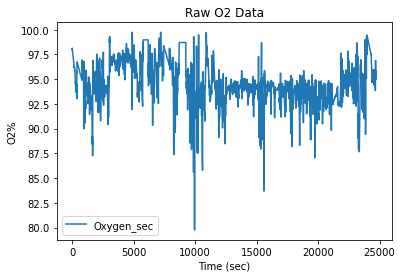

In [24]:
df.plot(y=['Oxygen_sec'])
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
plt.title('Raw O2 Data')


Text(0.5, 1.0, 'Baseline and Raw O2 Data')

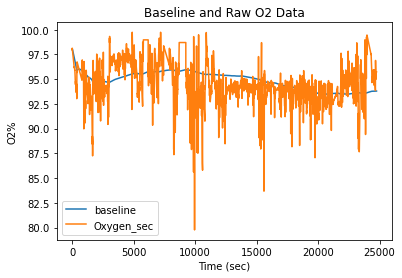

In [25]:
#set up slow-moving average filter parameters to establish baseline and support comparison for artifact detection
t_slow =10800 #assume that "t_slow" in sample data refers to slow-moving average time constant for baseline.  This is a guess.
eventReadings = 1 #require this many consecutive readings below desat threshold before scoring event
desatThreshold = 3 #percent below baseline
artifactRate = 3 #don't register desaturation events if O2 changes by more than this rate from one reading to the next (percent)
longEventDuration = 60 #number of seconds required to score "long" event

df['baseline'] = df['Oxygen_sec'].rolling(t_slow,min_periods = 1).mean()

df.plot(y=['baseline','Oxygen_sec'])
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
plt.title('Baseline and Raw O2 Data')

In [26]:
df_filter['reference'] = df_filter['Oxygen_sec'].rolling(5,min_periods = 1).mean()

<ipython-input-26-7ff64225e389>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['reference'] = df_filter['Oxygen_sec'].rolling(5,min_periods = 1).mean()


In [27]:
df_filter

,Oxygen_sec,pulse_sec,stage_min,stage_sec,interval,reference
0,97.99,68,0.0,0.0,6.99,97.990000
1,98.01,68,0.0,0.0,7.01,98.000000
2,98.04,68,0.0,0.0,7.04,98.013333
3,98.06,68,0.0,0.0,7.06,98.025000
4,98.10,68,0.0,0.0,7.10,98.040000
...,...,...,...,...,...,...
24741,95.75,84,NaN,0.0,4.75,95.750000
24742,95.75,84,NaN,0.0,4.75,95.750000
24743,95.75,84,NaN,0.0,4.75,95.750000
24744,95.75,84,NaN,0.0,4.75,95.750000


In [28]:
interval_ind=(df_filter['Oxygen_sec']-df_filter['reference'])/df_filter['reference']*100 #interval percentage based off of personal data per every 5 seconds

In [29]:
df_filter['interval_ind']=interval_ind
df_filter

<ipython-input-29-6cd495977d0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['interval_ind']=interval_ind


,Oxygen_sec,pulse_sec,stage_min,stage_sec,interval,reference,interval_ind
0,97.99,68,0.0,0.0,6.99,97.990000,0.000000e+00
1,98.01,68,0.0,0.0,7.01,98.000000,1.020408e-02
2,98.04,68,0.0,0.0,7.04,98.013333,2.720718e-02
3,98.06,68,0.0,0.0,7.06,98.025000,3.570518e-02
4,98.10,68,0.0,0.0,7.10,98.040000,6.119951e-02
...,...,...,...,...,...,...,...
24741,95.75,84,NaN,0.0,4.75,95.750000,-4.467329e-12
24742,95.75,84,NaN,0.0,4.75,95.750000,-4.467329e-12
24743,95.75,84,NaN,0.0,4.75,95.750000,-4.467329e-12
24744,95.75,84,NaN,0.0,4.75,95.750000,-4.467329e-12


Text(0.5, 1.0, 'raw O2 Data and 91% reference')

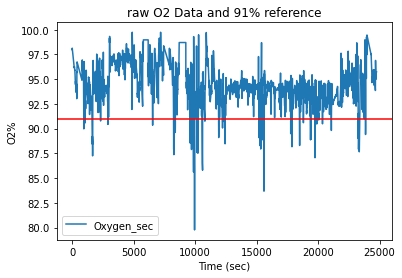

In [30]:
#overall oxygen level comparing to the reference line which is at 91%
df.plot(y=['Oxygen_sec'])
plt.axhline(y=91, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
plt.title('raw O2 Data and 91% reference')


Text(0.5, 1.0, 'filtered O2 Data and 91% reference')

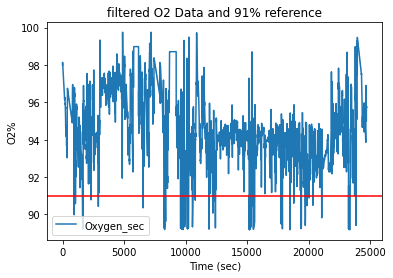

In [31]:
#filtered oxygen level, where the oxygen levels are only accounted not due to device malfunction
#comparing to the reference line which is at 91%
df_filter.plot(y=['Oxygen_sec'])
plt.axhline(y=91, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
plt.title('filtered O2 Data and 91% reference')


Text(0.5, 1.0, 'filtered O2 Data and 91% reference')

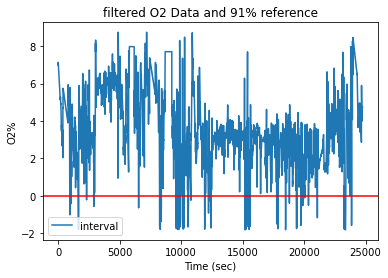

In [32]:
df_filter.plot(y=['interval'])
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Time (sec)')
plt.ylabel('O2%')
plt.title('filtered O2 Data and 91% reference')


In [33]:
#filter out the positive interval because they are fine (healthy to have high oxygen level, right?)

df_filter_neg=df_filter[(df_filter['interval_ind'] <= 0)]

In [34]:
df_filter_neg

,Oxygen_sec,pulse_sec,stage_min,stage_sec,interval,reference,interval_ind
0,97.99,68,0.0,0.0,6.99,97.990,0.000000e+00
8,98.10,68,0.0,0.0,7.10,98.114,-1.426912e-02
9,98.09,68,0.0,0.0,7.09,98.112,-2.242335e-02
10,98.08,68,0.0,0.0,7.08,98.100,-2.038736e-02
11,98.06,68,0.0,0.0,7.06,98.088,-2.854580e-02
...,...,...,...,...,...,...,...
24741,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12
24742,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12
24743,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12
24744,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12


In [35]:
min(df_filter_neg['interval_ind'])

-3.0294393094193133

In [36]:
ODI3=df_filter_neg['interval_ind'] <= -3 # ODI 3%, oxygen level drops more or equal to 3 percent
ODI2=df_filter_neg['interval_ind'] <= -2  # ODI 2%, oxygen level drops more or equal to 2 percent
ODI1=df_filter_neg['interval_ind'] <= -1  # ODI 1%, oxygen level drops more or equal to 1 percent

In [37]:
ODI3

0        False
8        False
9        False
10       False
11       False
         ...  
24741    False
24742    False
24743    False
24744    False
24745    False
Name: interval_ind, Length: 14288, dtype: bool

In [38]:
df_filter_neg['ODI1']=ODI1
df_filter_neg['ODI2']=ODI2
df_filter_neg['ODI3']=ODI3

<ipython-input-38-81ed0c887039>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI1']=ODI1
<ipython-input-38-81ed0c887039>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI2']=ODI2
<ipython-input-38-81ed0c887039>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [39]:
df_filter_neg['ODI'] = df_filter_neg['interval_ind'].values

<ipython-input-39-a11872e6578a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI'] = df_filter_neg['interval_ind'].values


In [40]:
# create a list of our conditions
conditions = [
    (df_filter_neg['interval_ind'] <=-3),
    (df_filter_neg['interval_ind'] <=-2) & (df_filter_neg['interval_ind'] >-3),
    (df_filter_neg['interval_ind'] >-2 ) & (df_filter_neg['interval_ind'] <=-1)
    ]

# create a list of the values we want to assign for each condition
values = ['ODI3', 'ODI2', 'ODI1']

# create a new column and use np.select to assign values to it using our lists as arguments
df_filter_neg['ODI'] = np.select(conditions, values)

# display updated DataFrame
df_filter_neg.head()

<ipython-input-40-ce0c4ad8b750>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter_neg['ODI'] = np.select(conditions, values)


,Oxygen_sec,pulse_sec,stage_min,stage_sec,interval,reference,interval_ind,ODI1,ODI2,ODI3,ODI
0,97.99,68,0.0,0.0,6.99,97.990,0.000000,False,False,False,0
8,98.10,68,0.0,0.0,7.10,98.114,-0.014269,False,False,False,0
9,98.09,68,0.0,0.0,7.09,98.112,-0.022423,False,False,False,0
10,98.08,68,0.0,0.0,7.08,98.100,-0.020387,False,False,False,0
11,98.06,68,0.0,0.0,7.06,98.088,-0.028546,False,False,False,0


In [41]:
df_filter_neg

,Oxygen_sec,pulse_sec,stage_min,stage_sec,interval,reference,interval_ind,ODI1,ODI2,ODI3,ODI
0,97.99,68,0.0,0.0,6.99,97.990,0.000000e+00,False,False,False,0
8,98.10,68,0.0,0.0,7.10,98.114,-1.426912e-02,False,False,False,0
9,98.09,68,0.0,0.0,7.09,98.112,-2.242335e-02,False,False,False,0
10,98.08,68,0.0,0.0,7.08,98.100,-2.038736e-02,False,False,False,0
11,98.06,68,0.0,0.0,7.06,98.088,-2.854580e-02,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...
24741,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0
24742,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0
24743,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0
24744,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0


In [42]:

#Drops equivalent or more than 3% event
event_ODI3 = sum(ODI3)

#Drops equivalent or more than 2% event
event_ODI2 = sum(ODI2)

#Drops equivalent or more than 1% event
event_ODI1 = sum(ODI1)

#drops 1% only
event_ODI1_only=event_ODI1-event_ODI2

#drops 2% only
event_ODI2_only=event_ODI2-event_ODI3


In [43]:
event_ODI=[event_ODI3,event_ODI2,event_ODI1]
print(event_ODI)
#event_ODI_only=[event_ODI3_only,event_ODI2_only,event_ODI1]
#event_ODI_only

[1, 8, 123]


Text(0.0, 1.0, 'Oxygen performance comparing to 91% level in percent\n')

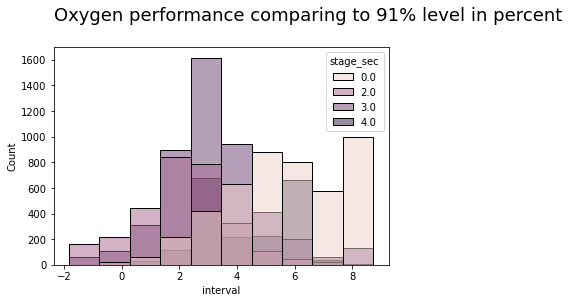

In [44]:
#stage corresponding to drop/increase comparing to 91% levels
sns.histplot(data=df_filter_neg, x='interval',
             hue='stage_sec',
             cbar=True,
             bins=10)
plt.title("Oxygen performance comparing to 91% level in percent\n",
          fontsize=18, loc='left'
         )

In [45]:

ODI_by_stage=df_filter_neg.groupby(['stage_sec'])['ODI3','ODI2','ODI1'].sum()

<ipython-input-45-e47f22636699>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ODI_by_stage=df_filter_neg.groupby(['stage_sec'])['ODI3','ODI2','ODI1'].sum()


In [46]:
ODI_by_stage

,ODI3,ODI2,ODI1
stage_sec,,,
0.0,0,0,1
2.0,0,5,76
3.0,1,3,36
4.0,0,0,10


In [47]:
ODI_by_stage.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4 entries, 0.0 to 4.0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ODI3    4 non-null      int64
 1   ODI2    4 non-null      int64
 2   ODI1    4 non-null      int64
dtypes: int64(3)
memory usage: 128.0 bytes


Text(0.0, 1.0, 'ODI level by sleep stage\n')

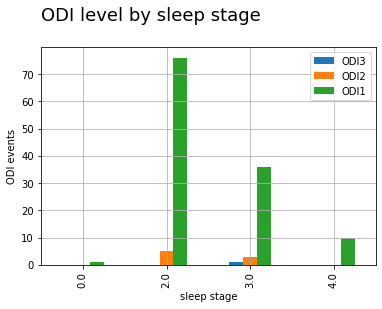

In [48]:
ODI_by_stage.plot.bar(stacked=False);


plt.xlabel('sleep stage')
plt.ylabel('ODI events')
plt.grid(True)
plt.title("ODI level by sleep stage\n",
          fontsize=18, loc='left'
         )

In [49]:
df_filter_neg

,Oxygen_sec,pulse_sec,stage_min,stage_sec,interval,reference,interval_ind,ODI1,ODI2,ODI3,ODI
0,97.99,68,0.0,0.0,6.99,97.990,0.000000e+00,False,False,False,0
8,98.10,68,0.0,0.0,7.10,98.114,-1.426912e-02,False,False,False,0
9,98.09,68,0.0,0.0,7.09,98.112,-2.242335e-02,False,False,False,0
10,98.08,68,0.0,0.0,7.08,98.100,-2.038736e-02,False,False,False,0
11,98.06,68,0.0,0.0,7.06,98.088,-2.854580e-02,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...
24741,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0
24742,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0
24743,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0
24744,95.75,84,NaN,0.0,4.75,95.750,-4.467329e-12,False,False,False,0


In [50]:
total_event=len(df)
oxy_level_1=sum(df['Oxygen_sec']<95) #events that is less than 95percent 
oxy_level_2=sum(df['Oxygen_sec']<90) #events that is less than 95percent 
oxy_level_3=sum(df['Oxygen_sec']<85) #events that is less than 85percent 
oxy_level_4=sum(df['Oxygen_sec']<80) #events that is less than 80percent

oxygen_average=round(oxygen_metric)


percent_oxy_level_1="{:.0%}".format(oxy_level_1/total_event) #percentage events that is less than 95percent
percent_oxy_level_2="{:.0%}".format(oxy_level_2/total_event) #percentage events that is less than 90percent
percent_oxy_level_3="{:.0%}".format(oxy_level_3/total_event) #percentage events that is less than 85percent
percent_oxy_level_4="{:.0%}".format(oxy_level_4/total_event) #percentage events that is less than 80percent



PR=int(df['pulse_sec'].mean()) #average pulse rate

sleep_stage0=int(sum(df['stage_sec']==0)/60) #sleep stage 0 in mins
sleep_stage1=int(sum(df['stage_sec']==1)/60) #sleep stage 0 in mins
sleep_stage2=int(sum(df['stage_sec']==2)/60) #sleep stage 0 in mins
sleep_stage3=int(sum(df['stage_sec']==3)/60) #sleep stage 0 in mins
sleep_stage4=int(sum(df['stage_sec']==4)/60) #sleep stage 0 in mins



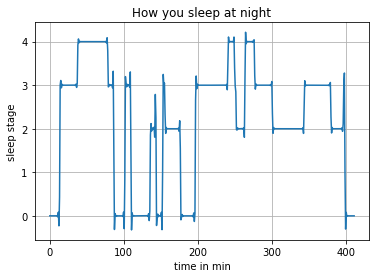

In [52]:
df_spec=df.dropna()


x = np.arange(0, len(df_spec['stage_min']), 1)
y = df_spec['stage_min'].to_numpy()

X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
plt.title("How you sleep at night")
plt.xlabel("time in min")
plt.ylabel("sleep stage")
plt.grid(True)
plt.show()

In [53]:
#print results to terminal for review
print("-----Some Other Relevant Results-----")
#print("Your expected oxygen intake level throughout the night is between" +' '+ str(expect_oxy) +'.')
print("Your average oxygen intake throughout the night is" +' '+ str(oxygen_average) +'%'+'.')
print("Your highest oxygen intake throughout the night is" +' '+ str(max_oxy) +'%'+'.')
print("Your lowest oxygen intake throughout the night is" +' '+ str(min_oxy) +'%'+'.')

print("Your oxygen intake below 95% of the night is" +' '+ str(oxy_level_1) +',' +"that is " + str(percent_oxy_level_1) +'of all the oxygen intake events.')
print("Your oxygen intake below 90% of the night is" +' '+ str(oxy_level_2) +',' +"that is " + str(percent_oxy_level_2) +'of all the oxygen intake events.')
print("Your oxygen intake below 85% of the night is" +' '+ str(oxy_level_3) +',' +"that is " + str(percent_oxy_level_3) +'of all the oxygen intake events.')
print("Your oxygen intake below 80% of the night is" +' '+ str(oxy_level_4) +',' +"that is " + str(percent_oxy_level_4) +'of all the oxygen intake events.')
print("The events of oxygen intake drops more than 3%" +' '+'happend '+ str(event_ODI3)+' '+'time(s).')

print("Your Average pulse rate of the night is " + str(PR) +'.')


print("Your sleep stage 0 of the night is " + str(sleep_stage0) +' '+'mins.')
print("Your sleep stage 1 of the night is " + str(sleep_stage1) + ' '+'mins.')
print("Your sleep stage 2 of the night is " + str(sleep_stage2) + ' '+'mins.')
print("Your sleep stage 3 of the night is " + str(sleep_stage3) +' '+'mins.')
print("Your sleep stage 4 of the night is " + str(sleep_stage4) +' '+'mins.')

-----Some Other Relevant Results-----
Your average oxygen intake throughout the night is 95%.
Your highest oxygen intake throughout the night is 99.75%.
Your lowest oxygen intake throughout the night is 79.76%.
Your oxygen intake below 95% of the night is 15776,that is 64%of all the oxygen intake events.
Your oxygen intake below 90% of the night is 654,that is 3%of all the oxygen intake events.
Your oxygen intake below 85% of the night is 25,that is 0%of all the oxygen intake events.
Your oxygen intake below 80% of the night is 1,that is 0%of all the oxygen intake events.
The events of oxygen intake drops more than 3% happend 1 time(s).
Your Average pulse rate of the night is 72.
Your sleep stage 0 of the night is 97 mins.
Your sleep stage 1 of the night is 0 mins.
Your sleep stage 2 of the night is 100 mins.
Your sleep stage 3 of the night is 152 mins.
Your sleep stage 4 of the night is 63 mins.
